# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [05:01<00:00, 1205.96it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [25]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn import model_selection
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [26]:
final["cleaned_text"] = preprocessed_reviews
print(final.shape)
final.head()


(364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [27]:
print(final["Score"].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


The data is imbalanced(i.e. There is huge difference count difference of two labels). So, Data need to be balanced using either UNDERSAMPLING or OVERSAMPLING. 

In [28]:
#Randomly taking 10000 points from each positive and negative reviews due to time and space complexity.
data_pos = final[final["Score"] ==1.0].sample(n=10000)
data_neg = final[final["Score"] ==0.0].sample(n=10000)
data_pos.head()

#concatenating the positive and negative reviews data 
final_cleaned_data = pd.concat([data_pos,data_neg],axis=0)

print(final_cleaned_data.shape)
final_cleaned_data.head()


(20000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
385494,416839,B000EH2VTW,A2F1QPIJTDWK55,Tara A. Green,0,0,1,1253750400,Best Rice and easy to cook!,Texmatic rice tastes incredible and is extreme...,texmatic rice tastes incredible extremely easy...
337550,365227,B001G8H4EA,A3KP25YIUY79SP,William Trask,14,14,1,1263427200,A good multi-purpose product,One issue of drinking home brewed spiced tea i...,one issue drinking home brewed spiced tea many...
122118,132364,B003JTAQZ8,A23PJHA99FYLYO,"soazsun ""soazsun""",0,0,1,1344038400,Superb Popcorn,Many years ago (too many) growing up as a kid ...,many years ago many growing kid no thing micro...
39554,42989,B002NHYQAS,ACWVXZ8VKJ19V,Karen S. Garvin,0,0,1,1298937600,Rich but not bitter,Newman's Own dark chocolate is labeled as 54% ...,newman dark chocolate labeled cocoa percentage...
430819,465913,B005OU6UD2,A16D635YJB575R,awesome shirts,0,0,1,1342656000,7 month old puppy loves them!,"I have a 7 month old poodle that's 7.8lbs, she...",month old poodle loves first got trial pack ti...


In [29]:
#time based splitting of the data
#converting time to date and time
final_cleaned_data["Time"] = pd.to_datetime(final_cleaned_data["Time"],unit="s")
final_cleaned_data = final_cleaned_data.sort_values(by = "Time")
final_cleaned_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
346037,374339,B00004CI84,AZRJH4JFB59VC,Lynwood E. Hines,21,23,0,2001-08-08,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...,continually amazed shoddy treatment movies get...
333930,361317,B00005IX96,A3ODTU118FKC5J,Rosemarie E Smith,5,7,1,2002-01-06,A little piece of heaven.,For years I have been trying to simulate a tru...,years trying simulate truly italian espresso c...
346040,374342,B00004CI84,A10L8O1ZMUIMR2,G. Kleinschmidt,61,79,0,2002-12-27,Great movie turned bad,"Just to let you know, this movie is one of my ...",let know movie one personal favorite ghost mov...
121056,131233,B00004RAMX,A1PYZPS1QYR036,"Kazantzakis ""hinterlands""",5,8,0,2003-10-29,Woodstream Gopher Trap 0610,This is a poor excuse for a gopher trap. I hav...,poor excuse gopher trap lots gophers used trap...
193572,209872,B0000D9N8O,AQFIH82DRPMW,Patrick O'Brien,64,64,1,2003-11-16,Wonderful Cheeses,Everyone in my family loves cheese and we espe...,everyone family loves cheese especially love f...


In [30]:
X = np.array(final_cleaned_data.loc[:,["cleaned_text"]])
Y = np.array(final_cleaned_data.loc[:,["Score"]])

#splitting the data into train and test.
X_train,x_test,Y_train,y_test = model_selection.train_test_split(X,Y,test_size = 0.3,random_state= 42)

x_train , x_cv,y_train,y_cv = model_selection.train_test_split(X_train,Y_train,test_size =0.3,random_state = 42)



In [31]:
#converting all into dataframes 
X_train = pd.DataFrame(X_train,columns = ["text"])
x_train = pd.DataFrame(x_train,columns = ["text"])
x_cv = pd.DataFrame(x_cv,columns =["text"])
x_test = pd.DataFrame(x_test,columns =["text"])


# Initialising the BOW vector representation
count_vec = CountVectorizer()
count_vec.fit(x_train["text"])
X_train_bow = count_vec.transform(X_train["text"])
x_train_bow = count_vec.transform(x_train["text"])
x_cv_bow = count_vec.transform(x_cv["text"])
x_test_bow = count_vec.transform(x_test["text"])


In [32]:
print(len(count_vec.get_feature_names()))
print(X_train_bow[1].toarray())

20337
[[0 0 0 ... 0 0 0]]


### Hyperparameter Tuning :- <FONT COLOR="RED">GRID SEARCH CV

In [33]:
#performing cross validation using gridsearchcv
from sklearn.metrics import roc_auc_score
roc_auc_train = []
roc_auc_cv = []
depth = [1, 5, 10, 50, 100, 500, 100]
samples_split = [5, 10, 100, 500]
parameters=dict(max_depth=depth,min_samples_split=samples_split)
clf=GridSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=5,return_train_score = True)

#fitting models
clf.fit(x_train_bow,y_train)


probcv=clf.predict_proba(x_cv_bow)[:,1]
roc_auc_cv.append(roc_auc_score(y_cv.ravel(),probcv))
probtr=clf.predict_proba(x_train_bow)[:,1]    
roc_auc_train.append(roc_auc_score(y_train.ravel(),probtr))
split_sam=clf.best_params_['min_samples_split']
tree_depth=clf.best_params_['max_depth']
print("The best sample is ",split_sam)
print("The best tree depth is ",tree_depth)



The best sample is  500
The best tree depth is  50


In [34]:
mean_test_score = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_["params"]
for i in range(len(parameters)):
    print("Test score is {0} for paramaters:{1}".format(mean_test_score[i],parameters[i]))
    

Test score is 0.5937635767652031 for paramaters:{'max_depth': 1, 'min_samples_split': 5}
Test score is 0.5937635767652031 for paramaters:{'max_depth': 1, 'min_samples_split': 10}
Test score is 0.5937635767652031 for paramaters:{'max_depth': 1, 'min_samples_split': 100}
Test score is 0.5937635767652031 for paramaters:{'max_depth': 1, 'min_samples_split': 500}
Test score is 0.7252384423748972 for paramaters:{'max_depth': 5, 'min_samples_split': 5}
Test score is 0.7256271840364129 for paramaters:{'max_depth': 5, 'min_samples_split': 10}
Test score is 0.7273161796249114 for paramaters:{'max_depth': 5, 'min_samples_split': 100}
Test score is 0.7239894465119161 for paramaters:{'max_depth': 5, 'min_samples_split': 500}
Test score is 0.7563352803275465 for paramaters:{'max_depth': 10, 'min_samples_split': 5}
Test score is 0.7588367199540321 for paramaters:{'max_depth': 10, 'min_samples_split': 10}
Test score is 0.7699300490465424 for paramaters:{'max_depth': 10, 'min_samples_split': 100}
Test 

In [35]:
#training the model
bow_model = tree.DecisionTreeClassifier(max_depth = 50,min_samples_split = 500)
bow_model.fit(x_train_bow,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

#### <font color="red"> PERFORMANCE METRICS

In [36]:
pred_bow = bow_model.predict(x_test_bow)
#train test accuracy
train_acc_bow = bow_model.score(x_train_bow,y_train.ravel())
test_acc_bow = bow_model.score(x_test_bow,y_test)

#train test ROC value
y_scores_bow_train = bow_model.predict_proba(x_train_bow)
fpr,tpr,thresholds = roc_curve(y_train,y_scores_bow_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_bow = auc(fpr,tpr)

y_scores_bow_test = bow_model.predict_proba(x_test_bow)
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_bow_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_bow = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_bow = precision_score(y_test, pred_bow) * 100
rec_bow = recall_score(y_test, pred_bow) * 100
f1_bow = f1_score(y_test, pred_bow) * 100


print("\nTrain accuracy=%f%%"% (train_acc_bow*100))
print("\nTest accuracy=%e%% "% (test_acc_bow*100))
print("\nTrain ROC value=%f"% (roc_auc_train_bow))
print("\nTest ROC value=%f"% (roc_auc_test_bow))
print('\nprecision=%f%%' % (pre_bow))
print('\nrecall=%f%%' % (rec_bow))
print('\nF1-Score=%f%%' % (f1_bow))




Train accuracy=78.275510%

Test accuracy=7.265000e+01% 

Train ROC value=0.867981

Test ROC value=0.791483

precision=71.446541%

recall=75.607321%

F1-Score=73.468068%


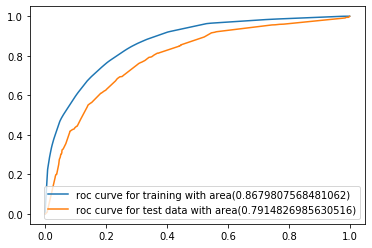

In [38]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc_train_bow))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_bow))
plt.legend(loc="lower right")
plt.show()

In [39]:
#Confusion Matrix
pred_bow = bow_model.predict(x_test_bow)    
from sklearn.metrics import confusion_matrix
cm_bow = confusion_matrix(y_test, pred_bow)
cm_bow

array([[2087,  908],
       [ 733, 2272]], dtype=int64)

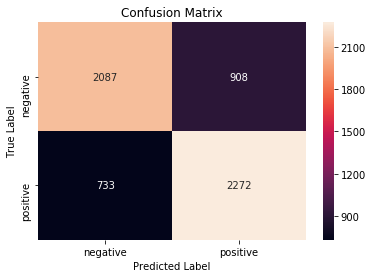

In [40]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [42]:
feat = count_vec.get_feature_names() 
coef =  bow_model.feature_importances_
print(coef)

[0. 0. 0. ... 0. 0. 0.]


In [43]:
#creating dataframe for features and weights.
frame = pd.DataFrame({'weight':coef,'features':feat})
frame.head()
# to get top 20 positive and negative features 
frame= frame.sort_values("weight", axis = 0 ,ascending = False, kind = 'quicksort',na_position = 'last')
frame.head()

,weight,features
7799,0.142671,great
11961,0.137947,not
1578,0.054629,best
4636,0.045216,delicious
13012,0.041839,perfect


In [44]:
# to get top 20 features 
print(frame.head(20).to_string(index=False))
#weight_vector.iloc[0:10,0:2]

   weight      features
 0.142671         great
 0.137947           not
 0.054629          best
 0.045216     delicious
 0.041839       perfect
 0.037723          good
 0.027973  disappointed
 0.025334      favorite
 0.021838          love
 0.020541         loves
 0.018557     excellent
 0.018212        highly
 0.017312          easy
 0.016927         happy
 0.014482           bad
 0.012937         tasty
 0.008912          nice
 0.008671            no
 0.008619       amazing
 0.008506     wonderful


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [46]:
#visualization of features through graphviz
import os
import graphviz 
os.environ["PATH"] += os.pathsep + 'C:/users/Ashok/Anaconda3/Library/bin/graphviz/'

dot_data = tree.export_graphviz(bow_model, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tree_representation_of_bow_model") 


'tree_representation_of_bow_model.pdf'


The required folder could be found in the same directory of this ipython notebook.

In [111]:
from prettytable import PrettyTable
x = PrettyTable()

max_depth_bow = 50
max_split_bow = 500
cv = 'GridSearchCv'
x.field_names = ["CV","max_depth","max_split","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","Auc_train","Auc_test"]


err_train_bow = np.around(100 - train_acc_bow*100 , decimals = 2)
err_test_bow =  np.around(100 - test_acc_bow*100 , decimals = 2)
pre_bow= np.around(pre_bow, decimals = 2)
rec_bow = np.around(rec_bow, decimals = 2)
f1_bow = np.around(f1_bow, decimals = 2)
AUC_train_bow = np.around(roc_auc_train_bow,decimals=2)
AUC_test_bow = np.around(roc_auc_test_bow,decimals=2)

x.add_row([cv,max_depth_bow,max_split_bow,err_train_bow,err_test_bow,pre_bow,rec_bow,f1_bow,AUC_train_bow,AUC_test_bow])


print(x)

+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
|      CV      | max_depth | max_split | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | Auc_train | Auc_test |
+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
| GridSearchCv |     50    |    500    |     21.72      |     27.35     |    71.45     |   75.61   |    73.47    |    0.87   |   0.79   |
+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+


## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [47]:
# Please write all the code with proper documentation
final.shape
final_cleaned_data.shape
#splitting the data into train and test

X_tfidf = np.array(final_cleaned_data.loc[:,["cleaned_text"]])
Y_tfidf = np.array(final_cleaned_data.loc[:,["Score"]])

X_train,x_test,Y_train,y_test = model_selection.train_test_split(X_tfidf,Y_tfidf,test_size = 0.3,random_state= 42)

x_train , x_cv,y_train,y_cv = model_selection.train_test_split(X_train,Y_train,test_size =0.3,random_state = 42)

#converting all into dataframes 
X_train = pd.DataFrame(X_train,columns = ["text"])
x_train = pd.DataFrame(x_train,columns = ["text"])
x_cv = pd.DataFrame(x_cv,columns =["text"])
x_test = pd.DataFrame(x_test,columns =["text"])

# Initialising the TFIDF vetorizer
tfidf_vec = TfidfVectorizer(ngram_range =(1,2))
tfidf_vec.fit(X_train["text"])
X_train_tfidf = tfidf_vec.transform(X_train["text"])
x_train_tfidf = tfidf_vec.transform(x_train["text"])
x_cv_tfidf = tfidf_vec.transform(x_cv["text"])
x_test_tfidf = tfidf_vec.transform(x_test["text"])

#X_train = count_vec.transform(X_train["text"])
print(x_train_tfidf.shape)
print(y_train.shape)

(9800, 362982)
(9800, 1)


### Hyperparameter Tuning: <font color = "red">GridSearchCV

In [48]:
#performing cross validation using gridsearchcv
from sklearn.metrics import roc_auc_score
roc_auc_train = []
roc_auc_cv = []
depth = [1, 5, 10, 50, 100, 500, 100]
samples_split = [5, 10, 100, 500]
parameters=dict(max_depth=depth,min_samples_split=samples_split)
clf=GridSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=5,return_train_score = True)

#fitting models
clf.fit(x_train_tfidf,y_train)

clf.fit(x_train_tfidf,y_train.ravel())
probcv=clf.predict_proba(x_cv_tfidf)[:,1]
roc_auc_cv.append(roc_auc_score(y_cv.ravel(),probcv))
probtr=clf.predict_proba(x_train_tfidf)[:,1]    
roc_auc_train.append(roc_auc_score(y_train.ravel(),probtr))
split_sam=clf.best_params_['min_samples_split']
tree_depth=clf.best_params_['max_depth']
print("The best sample is ",split_sam)
print("The best tree depth is ",tree_depth)

The best sample is  500
The best tree depth is  50


In [49]:
mean_test_score = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_["params"]
for i in range(len(parameters)):
    print("Test score is {0} for paramaters:{1}".format(mean_test_score[i],parameters[i]))

Test score is 0.5897767590870109 for paramaters:{'max_depth': 1, 'min_samples_split': 5}
Test score is 0.5897767590870109 for paramaters:{'max_depth': 1, 'min_samples_split': 10}
Test score is 0.5897767590870109 for paramaters:{'max_depth': 1, 'min_samples_split': 100}
Test score is 0.5897767590870109 for paramaters:{'max_depth': 1, 'min_samples_split': 500}
Test score is 0.7199199128337586 for paramaters:{'max_depth': 5, 'min_samples_split': 5}
Test score is 0.7197316610774892 for paramaters:{'max_depth': 5, 'min_samples_split': 10}
Test score is 0.7206703021039974 for paramaters:{'max_depth': 5, 'min_samples_split': 100}
Test score is 0.7212442517057174 for paramaters:{'max_depth': 5, 'min_samples_split': 500}
Test score is 0.7615143496421554 for paramaters:{'max_depth': 10, 'min_samples_split': 5}
Test score is 0.7629328440829456 for paramaters:{'max_depth': 10, 'min_samples_split': 10}
Test score is 0.7682154611359621 for paramaters:{'max_depth': 10, 'min_samples_split': 100}
Test 

In [51]:
#training the model
tfidf_model = tree.DecisionTreeClassifier(max_depth = 50,min_samples_split = 500)
tfidf_model.fit(x_train_tfidf,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

#### <font color="red"> PERFORMANCE METRICS

In [52]:
pred_tfidf = tfidf_model.predict(x_test_tfidf)
#train test accuracy
train_acc_tfidf = tfidf_model.score(x_train_tfidf,y_train.ravel())
test_acc_tfidf = tfidf_model.score(x_test_tfidf,y_test)

#train test ROC value
y_scores_tfidf_train = tfidf_model.predict_proba(x_train_tfidf)
fpr,tpr,thresholds = roc_curve(y_train,y_scores_tfidf_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_tfidf = auc(fpr,tpr)

y_scores_tfidf_test = tfidf_model.predict_proba(x_test_tfidf)
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_tfidf_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_tfidf = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_tfidf = precision_score(y_test, pred_tfidf) * 100
rec_tfidf = recall_score(y_test, pred_tfidf) * 100
f1_tfidf = f1_score(y_test, pred_tfidf) * 100


print("\nTrain accuracy=%f%%"% (train_acc_tfidf*100))
print("\nTest accuracy=%e%% "% (test_acc_tfidf*100))
print("\nTrain ROC value=%f"% (roc_auc_train_tfidf))
print("\nTest ROC value=%f"% (roc_auc_test_tfidf))
print('\nprecision=%f%%' % (pre_tfidf))
print('\nrecall=%f%%' % (rec_tfidf))
print('\nF1-Score=%f%%' % (f1_tfidf))




Train accuracy=81.540816%

Test accuracy=7.310000e+01% 

Train ROC value=0.890318

Test ROC value=0.786077

precision=70.829590%

recall=78.702163%

F1-Score=74.558638%


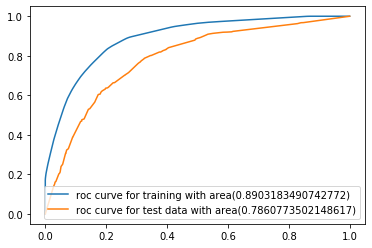

In [53]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc_train_tfidf))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_tfidf))
plt.legend(loc="lower right")
plt.show()

In [54]:
#Confusion Matrix
pred_tfidf = tfidf_model.predict(x_test_tfidf)    
from sklearn.metrics import confusion_matrix
cm_tfidf = confusion_matrix(y_test, pred_tfidf)
cm_tfidf

array([[2021,  974],
       [ 640, 2365]], dtype=int64)

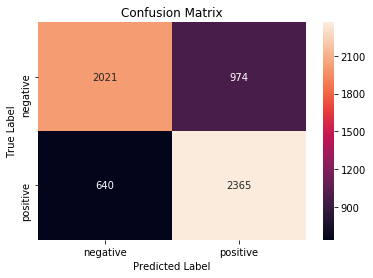

In [55]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [56]:
# Please write all the code with proper documentation
feats = tfidf_vec.get_feature_names() 

In [57]:
coef =  tfidf_model.feature_importances_
print(coef)

[0. 0. 0. ... 0. 0. 0.]


In [59]:
frame = pd.DataFrame({'weight':coef,'features':feats})
frame.head()
# to get top 20 positive and negative features 
frame= frame.sort_values("weight", axis = 0 ,ascending = False, kind = 'quicksort',na_position = 'last')
frame.head()

,weight,features
139281,0.130919,great
211207,0.118338,not
27087,0.052132,best
81755,0.042049,delicious
135448,0.040550,good


In [60]:
# to get top 20 features 
print(frame.head(20).to_string(index=False))
#weight_vector.iloc[0:10,0:2]

   weight      features
 0.130919         great
 0.118338           not
 0.052132          best
 0.042049     delicious
 0.040550          good
 0.038418       perfect
 0.031416          love
 0.029497          easy
 0.023998        highly
 0.020399      favorite
 0.020210         loves
 0.019715     excellent
 0.018476          nice
 0.016051      not good
 0.015712         tasty
 0.015431  disappointed
 0.013920           bad
 0.009976     wonderful
 0.009462         waste
 0.009081       amazing


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [61]:
# Please write all the code with proper documentation
#visualization of features through graphviz
import os
import graphviz 
os.environ["PATH"] += os.pathsep + 'C:/users/Ashok/Anaconda3/Library/bin/graphviz/'

dot_data = tree.export_graphviz(tfidf_model, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tree_representation_of_tfidf_model") 


'tree_representation_of_tfidf_model.pdf'

In [112]:
from prettytable import PrettyTable
x = PrettyTable()

max_depth_tfidf = 50
max_split_tfidf = 500
cv = 'GridSearchCv'
x.field_names = ["CV","max_depth","max_split","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","Auc_train","Auc_test"]


err_train_tfidf = np.around(100 - train_acc_tfidf*100 , decimals = 2)
err_test_tfidf =  np.around(100 - test_acc_tfidf*100 , decimals = 2)
pre_tfidf= np.around(pre_tfidf, decimals = 2)
rec_tfidf = np.around(rec_tfidf, decimals = 2)
f1_tfidf = np.around(f1_tfidf, decimals = 2)
AUC_train_tfidf = np.around(roc_auc_train_tfidf,decimals=2)
AUC_test_tfidf = np.around(roc_auc_test_tfidf,decimals=2)

x.add_row([cv,max_depth_tfidf,max_split_tfidf,err_train_tfidf,err_test_tfidf,pre_tfidf,rec_tfidf,f1_tfidf,AUC_train_tfidf,AUC_test_tfidf])


print(x)

+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
|      CV      | max_depth | max_split | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | Auc_train | Auc_test |
+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
| GridSearchCv |     50    |    500    |     18.46      |      26.9     |    70.83     |    78.7   |    74.56    |    0.89   |   0.79   |
+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+


## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [62]:
# Please write all the code with proper documentations
#converting all the dataframe into list.

X_train_w2v = X_train["text"].tolist() 
x_train_w2v = x_train["text"].tolist()
x_cv_w2v = x_cv["text"].tolist()
x_test_w2v = x_test["text"].tolist()

In [63]:
#storing  all the datasets into one list
data_for_w2v = []
data_for_w2v.append(X_train_w2v)
data_for_w2v.append(x_train_w2v)
data_for_w2v.append(x_cv_w2v)
data_for_w2v.append(x_test_w2v)

In [64]:
# Train your own Word2Vec model using your own text corpus

#appending the text for train test crossval in one list.
#note: 
    # index 0 implies x_1 data
    #index 1 implies x_train data
    # index 2 implies x_crossval data
    #index 3 implies x_test data
    

count = 0
list_of_sentance_for_w2v = []
for i in data_for_w2v:
    locals()['list_of_sentance_{}'.format(count)] = []
    for sentance in i:
        locals()['list_of_sentance_{}'.format(count)].append(sentance.split())
        
    count +=1
    
list_of_sentance_for_w2v.append(list_of_sentance_0) 
list_of_sentance_for_w2v.append(list_of_sentance_1) 
list_of_sentance_for_w2v.append(list_of_sentance_2) 
list_of_sentance_for_w2v.append(list_of_sentance_3)


In [65]:
#Training w2v model / converting texts into vectors.

counts = 0
for i in list_of_sentance_for_w2v:
    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True

    if want_to_train_w2v:
        # min_count = 5 considers only words that occured atleast 5 times
         # min_count = 5 considers only words that occured atleast 5 times
        #w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
   
        locals()['w2v_model_{}'.format(counts)]=Word2Vec(i,min_count=5,size=50, workers=4)  # models for train and test data
        locals()['w2v_words_{}'.format(counts)] = list(locals()['w2v_model_{}'.format(counts)].wv.vocab) #words of train and test data
    
    
    elif want_to_use_google_w2v and is_your_ram_gt_16g:
        if os.path.isfile('GoogleNews-vectors-negative300.bin'):
            w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
    counts+=1            
            
print(w2v_model_0)    # x_1 data
print(w2v_model_1)  #x_train data
print(w2v_model_2)    #x_crossval data
print(w2v_model_3)  #x_test data
print(w2v_words_1[6])


Word2Vec(vocab=7548, size=50, alpha=0.025)
Word2Vec(vocab=6260, size=50, alpha=0.025)
Word2Vec(vocab=3842, size=50, alpha=0.025)
Word2Vec(vocab=4802, size=50, alpha=0.025)
waste


In [66]:
# average Word2Vec
# compute average word2vec for each review.
# the avg-w2v for each sentence/review is stored in this list= []; # the avg-w2v for each sentence/review is stored in this list = []; # the avg-w2v for each sentence/review is stored in this list


k=0
vectors_for_avg_w2v = []
for i in list_of_sentance_for_w2v:
    locals()['data_{}'.format(k)] = []
    for sent in tqdm(i):
       # for each review/sentence
        sent_vec= np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in locals()['w2v_words_{}'.format(k)]:
                vec = locals()['w2v_model_{}'.format(k)].wv[word]
                sent_vec+= vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        locals()['data_{}'.format(k)].append(sent_vec)
    vectors_for_avg_w2v.append(locals()['data_{}'.format(k)]) 
    k+=1
            
           
##NOTE: vectors_for_avg_w2v list contains vectors representation of x_1, x_train , x_crossval , x_test.            
         
     

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:08<00:00, 691.38it/s]


### hyperparameter Tuning: <font color = "red"> GridSearchCV

In [67]:
#performing cross validation using gridsearchcv
from sklearn.metrics import roc_auc_score
roc_auc_train = []
roc_auc_cv = []
depth = [1, 5, 10, 50, 100, 500, 100]
samples_split = [5, 10, 100, 500]
parameters=dict(max_depth=depth,min_samples_split=samples_split)
clf=GridSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=5,return_train_score = True)

#fitting models
clf.fit(vectors_for_avg_w2v[1],y_train)

clf.fit(vectors_for_avg_w2v[1],y_train.ravel())
probcv=clf.predict_proba(vectors_for_avg_w2v[2])[:,1]
roc_auc_cv.append(roc_auc_score(y_cv.ravel(),probcv))
probtr=clf.predict_proba(vectors_for_avg_w2v[1])[:,1]    
roc_auc_train.append(roc_auc_score(y_train.ravel(),probtr))
split_sam=clf.best_params_['min_samples_split']
tree_depth=clf.best_params_['max_depth']
print("The best sample is ",split_sam)
print("The best tree depth is ",tree_depth)

The best sample is  100
The best tree depth is  5


In [68]:
mean_test_score = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_["params"]
for i in range(len(parameters)):
    print("Test score is {0} for paramaters:{1}".format(mean_test_score[i],parameters[i]))

Test score is 0.6250843625870844 for paramaters:{'max_depth': 1, 'min_samples_split': 5}
Test score is 0.6250843625870844 for paramaters:{'max_depth': 1, 'min_samples_split': 10}
Test score is 0.6250843625870844 for paramaters:{'max_depth': 1, 'min_samples_split': 100}
Test score is 0.6250843625870844 for paramaters:{'max_depth': 1, 'min_samples_split': 500}
Test score is 0.7256054848017062 for paramaters:{'max_depth': 5, 'min_samples_split': 5}
Test score is 0.7255148636179886 for paramaters:{'max_depth': 5, 'min_samples_split': 10}
Test score is 0.7260300427689341 for paramaters:{'max_depth': 5, 'min_samples_split': 100}
Test score is 0.7210561555114086 for paramaters:{'max_depth': 5, 'min_samples_split': 500}
Test score is 0.6699289945806526 for paramaters:{'max_depth': 10, 'min_samples_split': 5}
Test score is 0.6780616778722451 for paramaters:{'max_depth': 10, 'min_samples_split': 10}
Test score is 0.7256864061478168 for paramaters:{'max_depth': 10, 'min_samples_split': 100}
Test 

In [69]:
#training the model
w2v_avg_model = tree.DecisionTreeClassifier(max_depth = 5,min_samples_split = 100)
w2v_avg_model.fit(vectors_for_avg_w2v[1],y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

#### <font color="red"> Performance Metrics

In [70]:
pred_w2v_avg = w2v_avg_model.predict(vectors_for_avg_w2v[3])
#train test accuracy
train_acc_w2v_avg = w2v_avg_model.score(vectors_for_avg_w2v[1],y_train.ravel())
test_acc_w2v_avg = w2v_avg_model.score(vectors_for_avg_w2v[3],y_test)

#train test ROC value
y_scores_w2v_avg_train = w2v_avg_model.predict_proba(vectors_for_avg_w2v[1])
fpr,tpr,thresholds = roc_curve(y_train,y_scores_w2v_avg_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_w2v_avg = auc(fpr,tpr)

y_scores_w2v_avg_test = w2v_avg_model.predict_proba(vectors_for_avg_w2v[3])
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_w2v_avg_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_w2v_avg = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_w2v_avg = precision_score(y_test, pred_w2v_avg) * 100
rec_w2v_avg = recall_score(y_test, pred_w2v_avg) * 100
f1_w2v_avg = f1_score(y_test, pred_w2v_avg) * 100


print("\nTrain accuracy=%f%%"% (train_acc_w2v_avg*100))
print("\nTest accuracy=%e%% "% (test_acc_w2v_avg*100))
print("\nTrain ROC value=%f"% (roc_auc_train_w2v_avg))
print("\nTest ROC value=%f"% (roc_auc_test_w2v_avg))
print('\nprecision=%f%%' % (pre_w2v_avg))
print('\nrecall=%f%%' % (rec_w2v_avg))
print('\nF1-Score=%f%%' % (f1_w2v_avg))




Train accuracy=69.010204%

Test accuracy=5.370000e+01% 

Train ROC value=0.756969

Test ROC value=0.527941

precision=56.219178%

recall=34.143095%

F1-Score=42.484472%


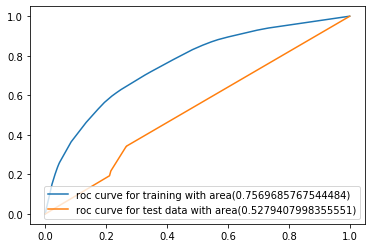

In [72]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc_train_w2v_avg))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_w2v_avg))
plt.legend(loc="lower right")
plt.show()

In [73]:
#Confusion Matrix
pred_avg_w2v = w2v_avg_model.predict(vectors_for_avg_w2v[3])    
from sklearn.metrics import confusion_matrix
cm_avg_w2v = confusion_matrix(y_test, pred_avg_w2v)
cm_avg_w2v

array([[2196,  799],
       [1979, 1026]], dtype=int64)

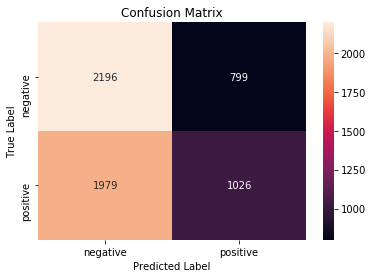

In [74]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_avg_w2v, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [113]:
from prettytable import PrettyTable
x = PrettyTable()

max_depth_avg = 5
max_split_avg = 100
cv = 'GridSearchCv'
x.field_names = ["CV","max_depth","max_split","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","Auc_train","Auc_test"]


err_train_w2v_avg = np.around(100 - train_acc_w2v_avg*100 , decimals = 2)
err_test_w2v_avg =  np.around(100 - test_acc_w2v_avg*100 , decimals = 2)
pre_w2v_avg= np.around(pre_w2v_avg, decimals = 2)
rec_w2v_avg = np.around(rec_w2v_avg, decimals = 2)
f1_w2v_avg = np.around(f1_w2v_avg, decimals = 2)
AUC_train_w2v_avg = np.around(roc_auc_train_w2v_avg,decimals=2)
AUC_test_w2v_avg = np.around(roc_auc_test_w2v_avg,decimals=2)

x.add_row([cv,max_depth_avg,max_split_avg,err_train_w2v_avg,err_test_w2v_avg,pre_w2v_avg,rec_w2v_avg,f1_w2v_avg,AUC_train_w2v_avg,AUC_test_w2v_avg])


print(x)

+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
|      CV      | max_depth | max_split | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | Auc_train | Auc_test |
+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
| GridSearchCv |     5     |    100    |     30.99      |      46.3     |    56.22     |   34.14   |    42.48    |    0.76   |   0.53   |
+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+


## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [75]:
# CONVERTING TEST DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_test_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [76]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_test_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_test_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_test_tfidf_w2v.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [06:44<00:00, 14.85it/s]


In [77]:
# CONVERTING TRAIN DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [78]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_train_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_train_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_train_tfidf_w2v.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 9800/9800 [13:12<00:00, 12.36it/s]


In [79]:
# CONVERTING CROSS VALIDATION DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_cv_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [80]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_crossval_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_cv_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    x_crossval_tfidf_w2v.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4200/4200 [04:09<00:00, 16.83it/s]


In [81]:
# CONVERTING CROSS VALIDATION DATA SET INTO TFIDF W2V REPRESENTATION.
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [82]:
# TF-IDF weighted Word2Vec
tfidf_feat_1 = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tfidf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train_w2v): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_3 and word in tfidf_feat_1:
            vec = w2v_model_0.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_w2v.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 14000/14000 [29:28<00:00,  7.91it/s]


### Hyperparameter Tuning:<font color = "red"> gridSearchCV

In [90]:
#performing cross validation using gridsearchcv
from sklearn.metrics import roc_auc_score
roc_auc_train = []
roc_auc_cv = []
depth = [1, 5, 10, 50, 100, 500, 100]
samples_split = [5, 10, 100, 500]
parameters=dict(max_depth=depth,min_samples_split=samples_split)
clf=GridSearchCV(tree.DecisionTreeClassifier(),parameters, scoring='roc_auc', refit=True, cv=5,return_train_score = True)

#fitting models
clf.fit(x_train_tfidf_w2v,y_train)


probcv=clf.predict_proba(x_crossval_tfidf_w2v)[:,1]
roc_auc_cv.append(roc_auc_score(y_cv.ravel(),probcv))
probtr=clf.predict_proba(x_train_tfidf_w2v)[:,1]    
roc_auc_train.append(roc_auc_score(y_train.ravel(),probtr))
split_sam=clf.best_params_['min_samples_split']
tree_depth=clf.best_params_['max_depth']
print("The best sample is ",split_sam)
print("The best tree depth is ",tree_depth)



The best sample is  5
The best tree depth is  1


In [91]:
mean_test_score = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_["params"]
for i in range(len(parameters)):
    print("Test score is {0} for paramaters:{1}".format(mean_test_score[i],parameters[i]))

Test score is 0.5 for paramaters:{'max_depth': 1, 'min_samples_split': 5}
Test score is 0.5 for paramaters:{'max_depth': 1, 'min_samples_split': 10}
Test score is 0.5 for paramaters:{'max_depth': 1, 'min_samples_split': 100}
Test score is 0.5 for paramaters:{'max_depth': 1, 'min_samples_split': 500}
Test score is 0.5 for paramaters:{'max_depth': 5, 'min_samples_split': 5}
Test score is 0.5 for paramaters:{'max_depth': 5, 'min_samples_split': 10}
Test score is 0.5 for paramaters:{'max_depth': 5, 'min_samples_split': 100}
Test score is 0.5 for paramaters:{'max_depth': 5, 'min_samples_split': 500}
Test score is 0.5 for paramaters:{'max_depth': 10, 'min_samples_split': 5}
Test score is 0.5 for paramaters:{'max_depth': 10, 'min_samples_split': 10}
Test score is 0.5 for paramaters:{'max_depth': 10, 'min_samples_split': 100}
Test score is 0.5 for paramaters:{'max_depth': 10, 'min_samples_split': 500}
Test score is 0.5 for paramaters:{'max_depth': 50, 'min_samples_split': 5}
Test score is 0.5 

In [94]:
#training the model
tfidf_w2v_model = tree.DecisionTreeClassifier(max_depth = 1,min_samples_split = 5)
tfidf_w2v_model.fit(x_train_tfidf_w2v,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

#### <font color = "red"> Performance Metrics

In [95]:
pred_tfidf_w2v = tfidf_w2v_model.predict(x_test_tfidf_w2v)
#train test accuracy
train_acc_tfidf_w2v = tfidf_w2v_model.score(x_train_tfidf_w2v,y_train.ravel())
test_acc_tfidf_w2v = tfidf_w2v_model.score(x_test_tfidf_w2v,y_test)

#train test ROC value
y_scores_tfidf_w2v_train = tfidf_w2v_model.predict_proba(x_train_tfidf_w2v)
fpr,tpr,thresholds = roc_curve(y_train,y_scores_tfidf_w2v_train[:,1])     # only positive y_scores to be comsidered
roc_auc_train_tfidf_w2v = auc(fpr,tpr)

y_scores_tfidf_w2v_test = tfidf_w2v_model.predict_proba(x_test_tfidf_w2v)
fpr_1,tpr_1,thresholds = roc_curve(y_test,y_scores_tfidf_w2v_test[:,1])     # only positive y_scores to be comsidered
roc_auc_test_tfidf_w2v = auc(fpr_1,tpr_1)

#Precision , recall and f1_score 
pre_tfidf_w2v = precision_score(y_test, pred_tfidf_w2v) * 100
rec_tfidf_w2v = recall_score(y_test, pred_tfidf_w2v) * 100
f1_tfidf_w2v = f1_score(y_test, pred_tfidf_w2v) * 100


print("\nTrain accuracy=%f%%"% (train_acc_tfidf_w2v*100))
print("\nTest accuracy=%e%% "% (test_acc_tfidf_w2v*100))
print("\nTrain ROC value=%f"% (roc_auc_train_tfidf_w2v))
print("\nTest ROC value=%f"% (roc_auc_test_tfidf_w2v))
print('\nprecision=%f%%' % (pre_tfidf_w2v))
print('\nrecall=%f%%' % (rec_tfidf_w2v))
print('\nF1-Score=%f%%' % (f1_tfidf_w2v))




Train accuracy=50.020408%

Test accuracy=5.008333e+01% 

Train ROC value=0.500000

Test ROC value=0.500000

precision=50.083333%

recall=100.000000%

F1-Score=66.740700%


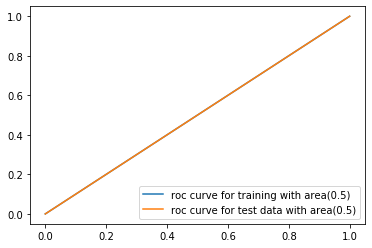

In [97]:
plt.figure()
plt.plot(fpr,tpr,label = "roc curve for training with area({})".format(roc_auc_train_tfidf_w2v))
plt.plot(fpr_1,tpr_1,label = "roc curve for test data with area({})".format(roc_auc_test_tfidf_w2v))
plt.legend(loc="lower right")
plt.show()

In [101]:
#Confusion Matrix
pred_w2v_tfidf = tfidf_w2v_model.predict(x_test_tfidf_w2v)    
from sklearn.metrics import confusion_matrix
cm_w2v_tfidf = confusion_matrix(y_test, pred_w2v_tfidf)
cm_w2v_tfidf

array([[   0, 2995],
       [   0, 3005]], dtype=int64)

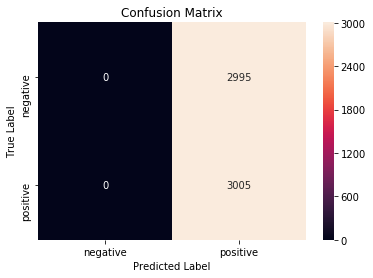

In [102]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_w2v_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [114]:
from prettytable import PrettyTable
x = PrettyTable()

max_depth_w2v = 1
max_split_w2v = 5
cv = 'GridSearchCv'
x.field_names = ["CV","max_depth","max_split","Train_error(%)","Test_error(%)","Precision(%)","Recall(%)","F1-Score(%)","Auc_train","Auc_test"]


err_train_tfidf_w2v = np.around(100 - train_acc_tfidf_w2v*100 , decimals = 2)
err_test_tfidf_w2v =  np.around(100 - test_acc_tfidf_w2v*100 , decimals = 2)
pre_tfidf_w2v= np.around(pre_tfidf_w2v, decimals = 2)
rec_tfidf_w2v = np.around(rec_tfidf_w2v, decimals = 2)
f1_tfidf_w2v = np.around(f1_tfidf_w2v, decimals = 2)
AUC_train_tfidf_w2v = np.around(roc_auc_train_tfidf_w2v,decimals=2)
AUC_test_tfidf_w2v = np.around(roc_auc_test_tfidf_w2v,decimals=2)

x.add_row([cv,max_depth_w2v,max_split_w2v,err_train_tfidf_w2v,err_test_tfidf_w2v,pre_tfidf_w2v,rec_tfidf_w2v,f1_tfidf_w2v,AUC_train_tfidf_w2v,AUC_test_tfidf_w2v])


print(x)

+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
|      CV      | max_depth | max_split | Train_error(%) | Test_error(%) | Precision(%) | Recall(%) | F1-Score(%) | Auc_train | Auc_test |
+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+
| GridSearchCv |     1     |     5     |     49.98      |     49.92     |    50.08     |   100.0   |    66.74    |    0.5    |   0.5    |
+--------------+-----------+-----------+----------------+---------------+--------------+-----------+-------------+-----------+----------+


In [125]:
from prettytable import PrettyTable
x = PrettyTable()


cv = 'GridSearchCv'
x.field_names = ["CV","Model","Train_error(%)","Test_error(%)","F1-Score(%)","Auc_train","Auc_test"]
model1="bow"
model2="tfidf"
model3="w2v_avg"
model4="tfidf_w2v"


x.add_row([cv,model1,err_train_bow,err_test_bow,f1_bow,AUC_train_bow,AUC_test_bow])
x.add_row([cv,model2,err_train_tfidf,err_test_tfidf,f1_tfidf,AUC_train_tfidf,AUC_test_tfidf])
x.add_row([cv,model3,err_train_w2v_avg,err_test_w2v_avg,f1_w2v_avg,AUC_train_w2v_avg,AUC_test_w2v_avg])
x.add_row([cv,model4,err_train_tfidf_w2v,err_test_tfidf_w2v,f1_tfidf_w2v,AUC_train_tfidf_w2v,AUC_test_tfidf_w2v])


print(x)

+--------------+-----------+----------------+---------------+-------------+-----------+----------+
|      CV      |   Model   | Train_error(%) | Test_error(%) | F1-Score(%) | Auc_train | Auc_test |
+--------------+-----------+----------------+---------------+-------------+-----------+----------+
| GridSearchCv |    bow    |     21.72      |     27.35     |    73.47    |    0.87   |   0.79   |
| GridSearchCv |   tfidf   |     18.46      |      26.9     |    74.56    |    0.89   |   0.79   |
| GridSearchCv |  w2v_avg  |     30.99      |      46.3     |    42.48    |    0.76   |   0.53   |
| GridSearchCv | tfidf_w2v |     49.98      |     49.92     |    66.74    |    0.5    |   0.5    |
+--------------+-----------+----------------+---------------+-------------+-----------+----------+


# [6] Conclusions
1. Decision Tree Algorithm with TFIDF representation is the best model so far with lowest error and higher AUC value.
2. Word2Vec representation should not be used with Decision Tree Algorithm for classification.
3. Decision Tree can be used for classification with Bow and Tfidf vector representation of text, considering more data's will give more better result for both models.
4. Given Dataset is Imbalanced so before training, it ought to be Balanced.